# CNN Tuning - Nombre de filtres - Extrême haut

## Objectif
L'objectif de ce notebook est de tester notre CNN en modifiant le nombre de filtres par couche de convolution avec des valeurs très hautes comparées à la référence.

## Hypothèses
Les hypothèses quant aux résultats attendus sont les suivantes :
- Une précision beaucoup plus faible que celle du CNN du template

## Etapes de la démarche
1. Dans la méthode create_model(), changer le nombre de filtres par couches de convolution
2. Dans la méthode create_model(), adapter les couches cachées de neurones
3. Tester le modèle sur le jeu de données
4. Calculer les métriques de performance
5. Comparer les résultats avec les résultats du CNN

## Conclusion
Les résultats obtenus sont les suivants :
- La précision du modèle modifiée a chuté contrairement au modèle d'origine (0.88 contre 0.92)
- Le temps d'entrainement est fortement rallongé
- Le CNN semble être sensible à une zone qui ne permet pas de détecter la pneumonie, notamment des lettres sur le haut de l'image

On peut en conclure que l'augmentation de neurones et de filtres n'est pas forcément gage de meilleurs résultats. La précision reste correcte, mais plus faible que le modèle d'origine. Le temps d'entrainement est également plus long et le CNN semble être sensible à une zone qui ne permet pas de détecter la pneumonie, notamment des lettres sur le haut de l'image.

In [1]:
# Check that GPU is used
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [1]:
from PIL import Image
import os
import numpy as np

# Define the folders where your data is stored
train_folder = 'train'
test_folder = 'test'
val_folder = 'val'

# Define the subfolders within each folder where the images are stored
subfolders = ['NORMAL', 'PNEUMONIA']

# Define the size of the images you want to resize your images to
img_width, img_height = 128, 128

In [2]:
# Function to load and resize images from a folder
def load_images_from_folder(folder, limit_per_subfolder=None):
    X = []
    y = []
    for subfolder in subfolders:
        folder_path = os.path.join(folder, subfolder)
        if limit_per_subfolder:
            # Get amount of random filenames from the folder
            filenames = np.random.choice(os.listdir(folder_path), limit_per_subfolder, replace=False)
        else:
            filenames = os.listdir(folder_path)
        for filename in filenames:
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path)

            # Resize the image to the desired size
            img = img.resize((img_width, img_height))

            # Convert RGB image to grayscale
            img = img.convert('L')

            # Convert the image to a NumPy array and append it to X
            img = np.array(img)
            X.append(img)

            # Append the corresponding label to y
            y.append(subfolders.index(subfolder))

    X = np.array(X)
    y = np.array(y)
    return X, y

In [3]:
# Generate augmented for the training set
from common.data_augmentation import generate_augmented_images
generate_augmented_images(train_folder, 'NORMAL', image_size=(img_width, img_height))
generate_augmented_images(train_folder, 'PNEUMONIA', image_size=(img_width, img_height))

Found 1341 images belonging to 1 classes.
Additional count of images to generate: 0
Given NORMAL count: 1341
Augmented NORMAL count: 5000
Found 3874 images belonging to 1 classes.
Additional count of images to generate: 0
Given PNEUMONIA count: 3874
Augmented PNEUMONIA count: 5000


In [4]:
# Load the training data
# Get min value between the number of normal images and the number of pneumonia images
train_folder = f"{train_folder}_augmented"
min_images = min(len(os.listdir(os.path.join(train_folder, subfolders[0]))), len(os.listdir(os.path.join(train_folder, subfolders[1]))))
X_train, y_train = load_images_from_folder(train_folder, min_images)

# Load the test data
X_test, y_test = load_images_from_folder(test_folder)

# Load the validation data
X_val, y_val = load_images_from_folder(val_folder)

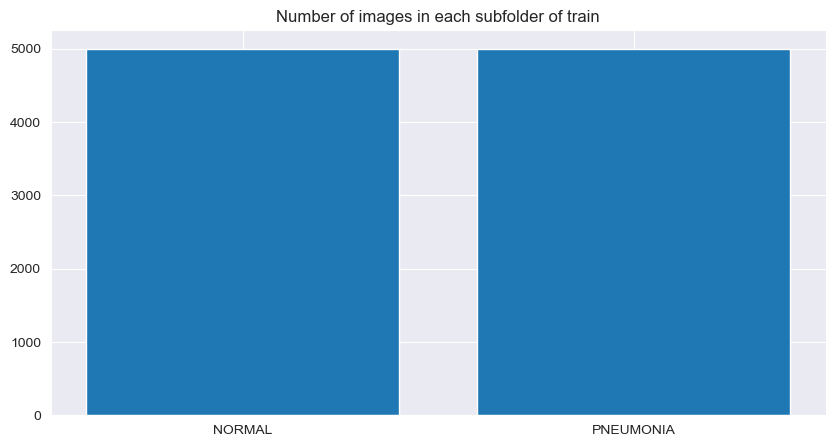

In [6]:
# Make a matplot figure to show how many images are in each subfolder of train
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.bar(subfolders, [len(os.listdir(os.path.join(train_folder, subfolder))) for subfolder in subfolders])
plt.title('Number of images in each subfolder of train')
plt.show()

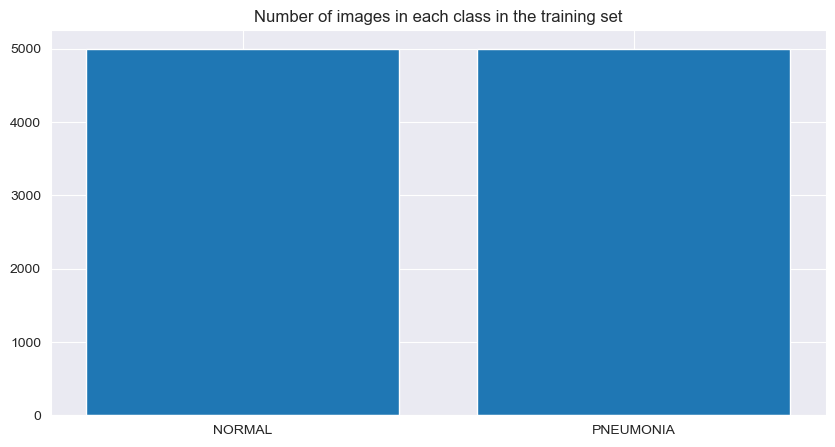

In [7]:
# Make a matplot figure to show how many images if each class in the training set
plt.figure(figsize=(10, 5))
plt.bar(subfolders, [len(y_train[y_train == i]) for i in range(len(subfolders))])
plt.title('Number of images in each class in the training set')
plt.show()

In [5]:
# Normalize the pixel values to be between 0 and 1
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
X_val = X_val.astype('float32') / 255

X_train = X_train.reshape(len(X_train), img_width, img_height, 1)
X_test = X_test.reshape(len(X_test), img_width, img_height, 1)
X_val = X_val.reshape(len(X_val), img_width, img_height, 1)

(128, 128, 1)


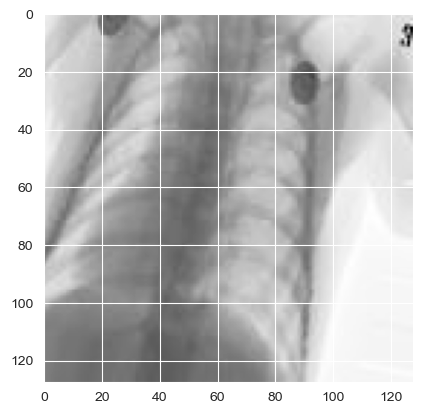

In [9]:
single_image = X_train[np.random.randint(len(X_train))]
print(single_image.shape)
plt.imshow(single_image, cmap='Greys')

In [10]:
# Define model metrics
from keras.metrics import AUC

metrics = [
    "accuracy",
    AUC(name='auc')
]

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the model architecture
def create_model():
    model = Sequential()

    model.add(Conv2D(filters=128, kernel_size=(3,3), input_shape=(img_width, img_height, 1), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=256, kernel_size=(3,3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=512, kernel_size=(3,3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=1024, kernel_size=(3,3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())

    model.add(Dense(1024, activation="relu"))
    model.add(Dropout(0.5))

    model.add(Dense(512, activation="relu"))
    model.add(Dropout(0.5))

    model.add(Dense(1, activation="sigmoid"))

    # compile the model
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=metrics)

    return model

In [8]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

In [13]:
# Cross validation
from sklearn.model_selection import KFold
from keras.preprocessing.image import ImageDataGenerator

# Define the number of folds for cross-validation
n_splits = 10
epochs = 7
batch_size = 64

# Initialize KFold with the number of folds
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Define lists to store the evaluation scores for each fold
accuracy_scores = []
histories = []
models = []

# Iterate through each fold and train/evaluate the model
for train_idx, val_idx in kf.split(X_train, y_train):
    # Split the data into training and validation sets for this fold
    X_train_fold, y_train_fold = X_train[train_idx], y_train[train_idx]
    X_val_fold, y_val_fold = X_train[val_idx], y_train[val_idx]

    # Create an instance of ImageDataGenerator to generate your image data
    datagen = ImageDataGenerator()

    # Create generators for training and validation data
    train_generator = datagen.flow(x=X_train_fold, y=y_train_fold, batch_size=batch_size)
    valid_generator = datagen.flow(x=X_val_fold, y=y_val_fold, batch_size=batch_size)

    # Create instance of the model for this fold and train it
    model = create_model()

    # Train your model on the training data for this fold
    history = model.fit(train_generator, validation_data=valid_generator, epochs=epochs, verbose=1, callbacks=[early_stop])
    histories.append(history.history)

    models.append(model)


Epoch 1/7
141/141 [==============================] - 178s 749ms/step - loss: 0.5949 - accuracy: 0.6556 - auc: 0.7342 - val_loss: 0.4124 - val_accuracy: 0.8060 - val_auc: 0.9050
Epoch 2/7
141/141 [==============================] - 79s 563ms/step - loss: 0.3243 - accuracy: 0.8610 - auc: 0.9354 - val_loss: 0.2579 - val_accuracy: 0.8860 - val_auc: 0.9606
Epoch 3/7
141/141 [==============================] - 76s 540ms/step - loss: 0.2577 - accuracy: 0.9002 - auc: 0.9594 - val_loss: 0.2394 - val_accuracy: 0.8910 - val_auc: 0.9667
Epoch 4/7
141/141 [==============================] - 72s 510ms/step - loss: 0.2103 - accuracy: 0.9219 - auc: 0.9718 - val_loss: 0.2029 - val_accuracy: 0.9220 - val_auc: 0.9771
Epoch 5/7
141/141 [==============================] - 75s 537ms/step - loss: 0.1834 - accuracy: 0.9329 - auc: 0.9778 - val_loss: 0.1821 - val_accuracy: 0.9310 - val_auc: 0.9819
Epoch 6/7
141/141 [==============================] - 80s 570ms/step - loss: 0.1619 - accuracy: 0.9384 - auc: 0.9830 - v

ResourceExhaustedError: Graph execution error:

Detected at node 'sequential_7/conv2d_29/Relu' defined at (most recent call last):
    File "C:\ProgramData\anaconda3\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\ProgramData\anaconda3\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\Eliott Clavier\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\ProgramData\anaconda3\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "C:\Users\Eliott Clavier\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "C:\ProgramData\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\ProgramData\anaconda3\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "C:\ProgramData\anaconda3\lib\asyncio\base_events.py", line 1906, in _run_once
      handle._run()
    File "C:\ProgramData\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Eliott Clavier\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "C:\Users\Eliott Clavier\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "C:\Users\Eliott Clavier\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "C:\Users\Eliott Clavier\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\Eliott Clavier\AppData\Roaming\Python\Python310\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\Eliott Clavier\AppData\Roaming\Python\Python310\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Eliott Clavier\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "C:\Users\Eliott Clavier\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "C:\Users\Eliott Clavier\AppData\Roaming\Python\Python310\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Eliott Clavier\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Eliott Clavier\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Eliott Clavier\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Eliott Clavier\AppData\Local\Temp\ipykernel_24368\2435153214.py", line 35, in <module>
      history = model.fit(train_generator, validation_data=valid_generator, epochs=epochs, verbose=1, callbacks=[early_stop])
    File "C:\ProgramData\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\ProgramData\anaconda3\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\ProgramData\anaconda3\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\ProgramData\anaconda3\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\ProgramData\anaconda3\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\ProgramData\anaconda3\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "C:\ProgramData\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\ProgramData\anaconda3\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\ProgramData\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\ProgramData\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\ProgramData\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\ProgramData\anaconda3\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "C:\ProgramData\anaconda3\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\ProgramData\anaconda3\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\ProgramData\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\ProgramData\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\ProgramData\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\ProgramData\anaconda3\lib\site-packages\keras\layers\convolutional\base_conv.py", line 314, in call
      return self.activation(outputs)
    File "C:\ProgramData\anaconda3\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "C:\ProgramData\anaconda3\lib\site-packages\keras\backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'sequential_7/conv2d_29/Relu'
OOM when allocating tensor with shape[64,256,61,61] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_7/conv2d_29/Relu}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_54276]

La cross validation n'a pu se conclure par manque de mémoire vive sur le GPU. Néanmoins, on observe que le modèle est très performant sur les données d'entrainement et que l'accuracy et l'AUC  d'entrainement et de validation restent cohérents entre chaque fold.

In [14]:
# Get accuracy scores for each fold (train and validation)
loss = []
acc = []
val_loss = []
val_acc = []

for history in histories:
    loss.append(np.mean(history["loss"]))
    acc.append(np.mean(history["accuracy"]))
    val_loss.append(np.mean(history["val_loss"]))
    val_acc.append(np.mean(history["val_accuracy"]))

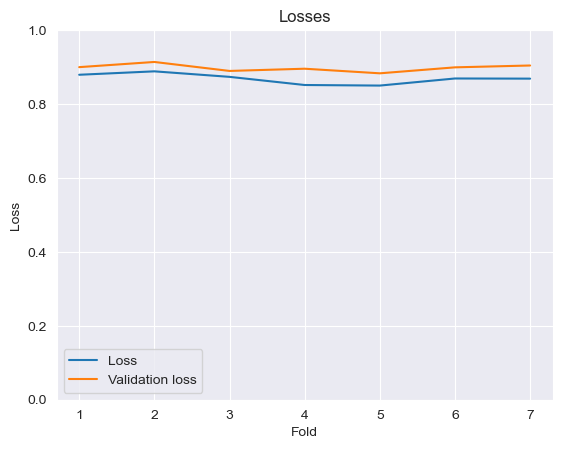

In [15]:
# Plot loss and validation loss per fold
import matplotlib.pyplot as plt
plt.title('Losses')
plt.plot(range(1, len(acc)+1), acc, label='Loss')
plt.plot(range(1, len(val_acc)+1), val_acc, label='Validation loss')
plt.ylim(0.0, 1.0)
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.legend()
plt.show()

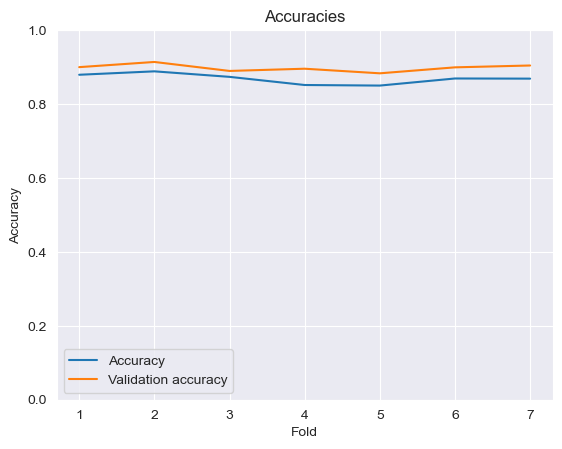

In [16]:
# Plot accuracies and validation accuracies per fold
import matplotlib.pyplot as plt
plt.title('Accuracies')
plt.plot(range(1, len(acc)+1), acc, label='Accuracy')
plt.plot(range(1, len(val_acc)+1), val_acc, label='Validation accuracy')
plt.ylim(0.0, 1.0)
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [11]:
# Train a final model with same parameters and save it
train_generator = datagen.flow(x=X_train, y=y_train, batch_size=batch_size)
valid_generator = datagen.flow(x=X_val, y=y_val, batch_size=batch_size)
model = create_model()
history = model.fit(train_generator, validation_data=valid_generator, epochs=epochs, verbose=1, callbacks=[early_stop])
model.save('cnn.h5')

Epoch 1/7
157/157 [==============================] - 29s 119ms/step - loss: 0.6294 - accuracy: 0.6493 - auc: 0.7116 - val_loss: 0.5091 - val_accuracy: 0.7500 - val_auc: 0.8281
Epoch 2/7
157/157 [==============================] - 17s 106ms/step - loss: 0.4923 - accuracy: 0.7722 - auc: 0.8477 - val_loss: 0.4386 - val_accuracy: 0.6875 - val_auc: 0.9062
Epoch 3/7
157/157 [==============================] - 17s 105ms/step - loss: 0.3375 - accuracy: 0.8613 - auc: 0.9290 - val_loss: 0.3355 - val_accuracy: 0.8750 - val_auc: 0.9531
Epoch 4/7
157/157 [==============================] - 17s 106ms/step - loss: 0.2469 - accuracy: 0.8989 - auc: 0.9613 - val_loss: 0.4491 - val_accuracy: 0.8125 - val_auc: 0.9062
Epoch 5/7
157/157 [==============================] - 17s 106ms/step - loss: 0.2154 - accuracy: 0.9163 - auc: 0.9705 - val_loss: 0.2818 - val_accuracy: 0.8750 - val_auc: 0.9531
Epoch 6/7
157/157 [==============================] - 17s 105ms/step - loss: 0.1834 - accuracy: 0.9298 - auc: 0.9782 - va

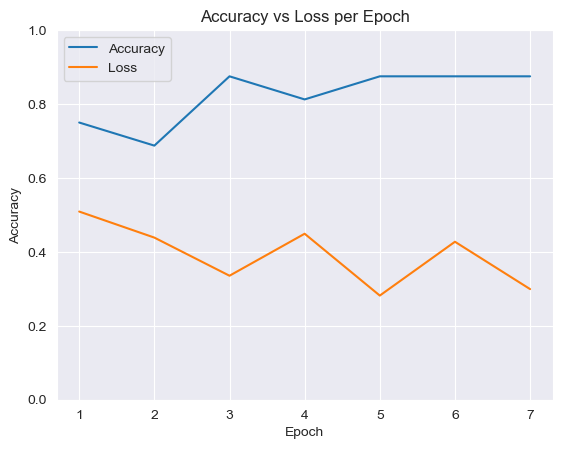

In [12]:
# Plot val accuracy and val loss of the trained model
import matplotlib.pyplot as plt
plt.title('Accuracy vs Loss per Epoch')
plt.plot(range(1, len(history.history["val_accuracy"])+1), history.history["val_accuracy"], label='Accuracy')
plt.plot(range(1, len(history.history["val_loss"])+1), history.history["val_loss"], label='Loss')
plt.ylim(0.0, 1.0)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
# Make predictions on the test set
y_pred_test = model.predict(X_test)
y_pred_test = np.where(y_pred_test >= 0.5, 1, 0)

20/20 [==============================] - 2s 13ms/step


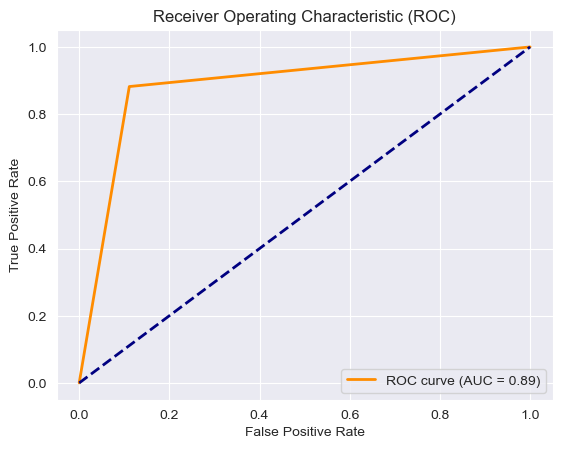

In [14]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and AUC score for the predictions
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(fpr, tpr)

# Plot ROC curve and show AUC score on the plot
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [15]:
from sklearn.metrics import confusion_matrix
# Compute the confusion matrix for test set
cm = confusion_matrix(y_test, y_pred_test.flatten())
print(cm)

[[208  26]
 [ 46 344]]


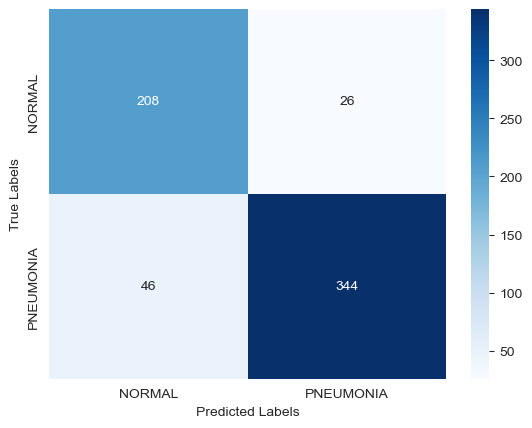

In [16]:
# Plot the confusion matrix
class_names = subfolders
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='g', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [17]:
# Compute the classification report for test set
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_test, target_names=class_names))

              precision    recall  f1-score   support

      NORMAL       0.82      0.89      0.85       234
   PNEUMONIA       0.93      0.88      0.91       390

    accuracy                           0.88       624
   macro avg       0.87      0.89      0.88       624
weighted avg       0.89      0.88      0.89       624



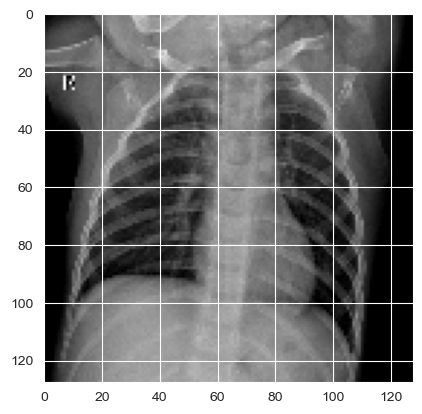

C:\ProgramData\anaconda3\lib\site-packages\keras\utils\image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


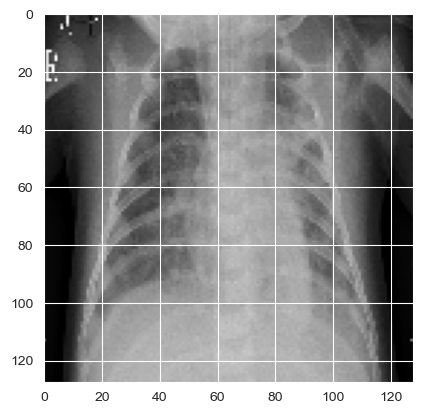

In [18]:
# Heatmaps and Grad-CAM
from common.cam import get_img_array
import cv2
import matplotlib.pyplot as plt 

images = [
    {
        "path": "./val/NORMAL/NORMAL2-IM-1442-0001.jpeg"
    },
    {
        "path": "./val/PNEUMONIA/person1946_bacteria_4874.jpeg"
    }
]

for image in images:
    image_temp = cv2.imread(image["path"])
    image_temp = cv2.cvtColor(image_temp, cv2.COLOR_RGB2GRAY)
    image_temp = cv2.resize(image_temp, (img_width, img_height))

    plt.imshow(image_temp, cmap=plt.cm.gray)
    plt.show()
    
    image["array"] = get_img_array(image["path"], size=(img_width, img_height))
    

In [19]:
# Remove last layer's softmax
model.layers[-1].activation = None

# import os
# os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [20]:
# Print model summary to get last max pooling layer name
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 126, 126, 128)     1280      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 63, 63, 128)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 61, 61, 256)       295168    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 256)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 512)       1180160   
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 512)     

In [23]:
# Select last conv layer
last_conv_layer_name = "max_pooling2d_7"

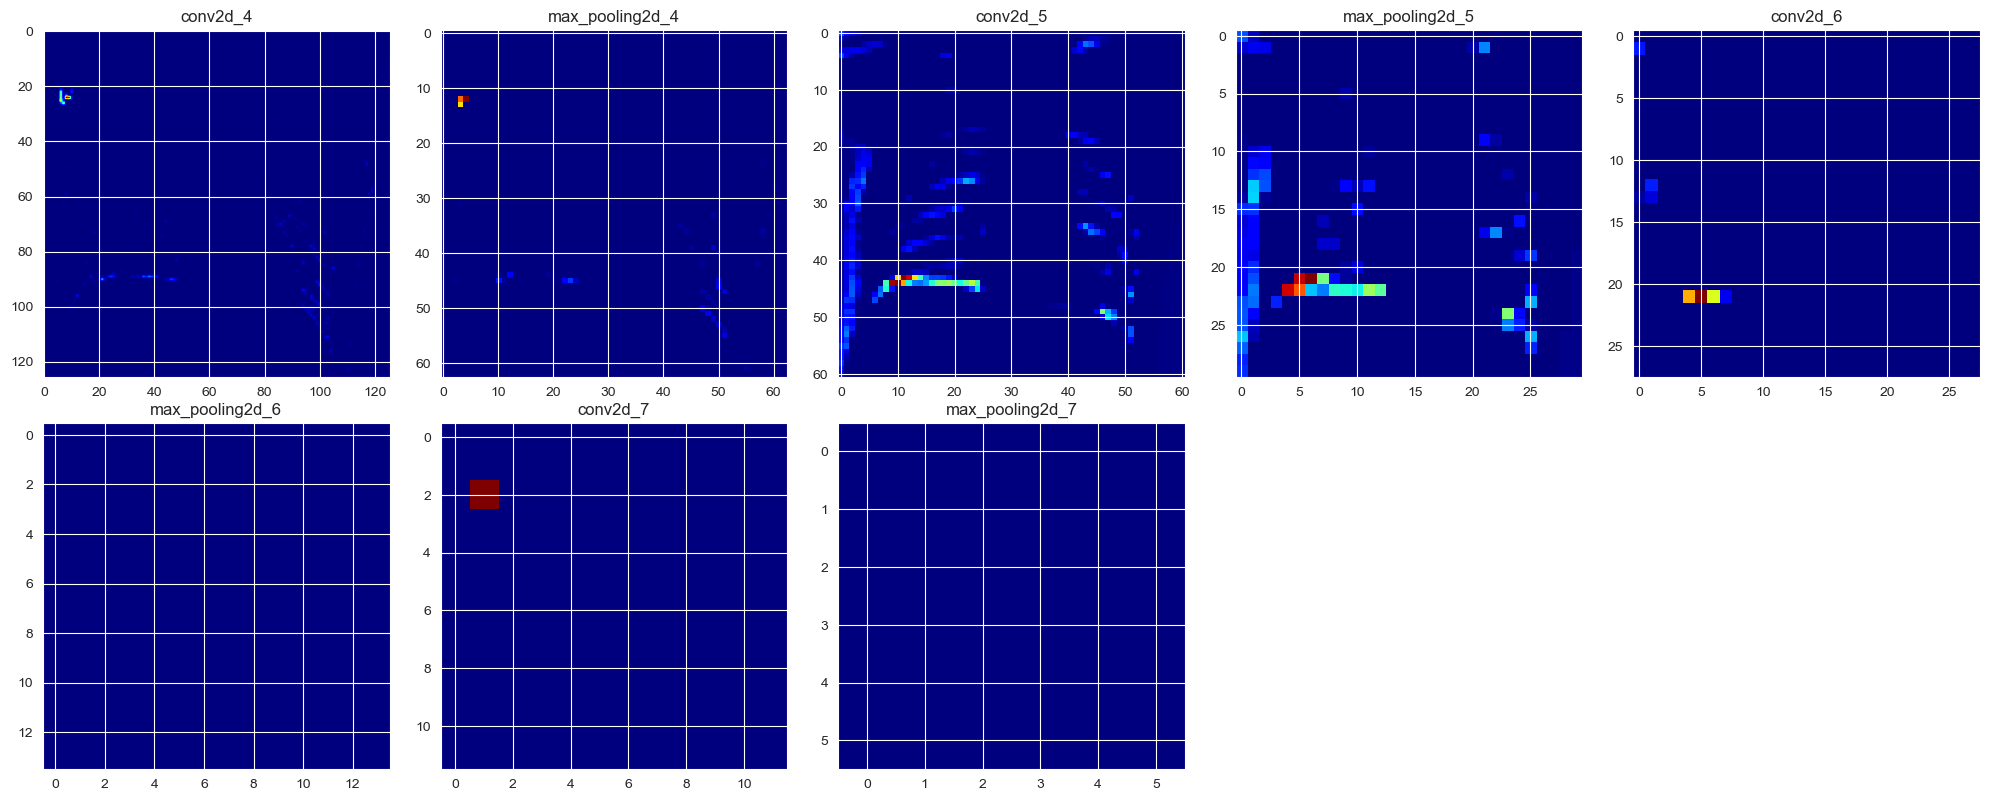

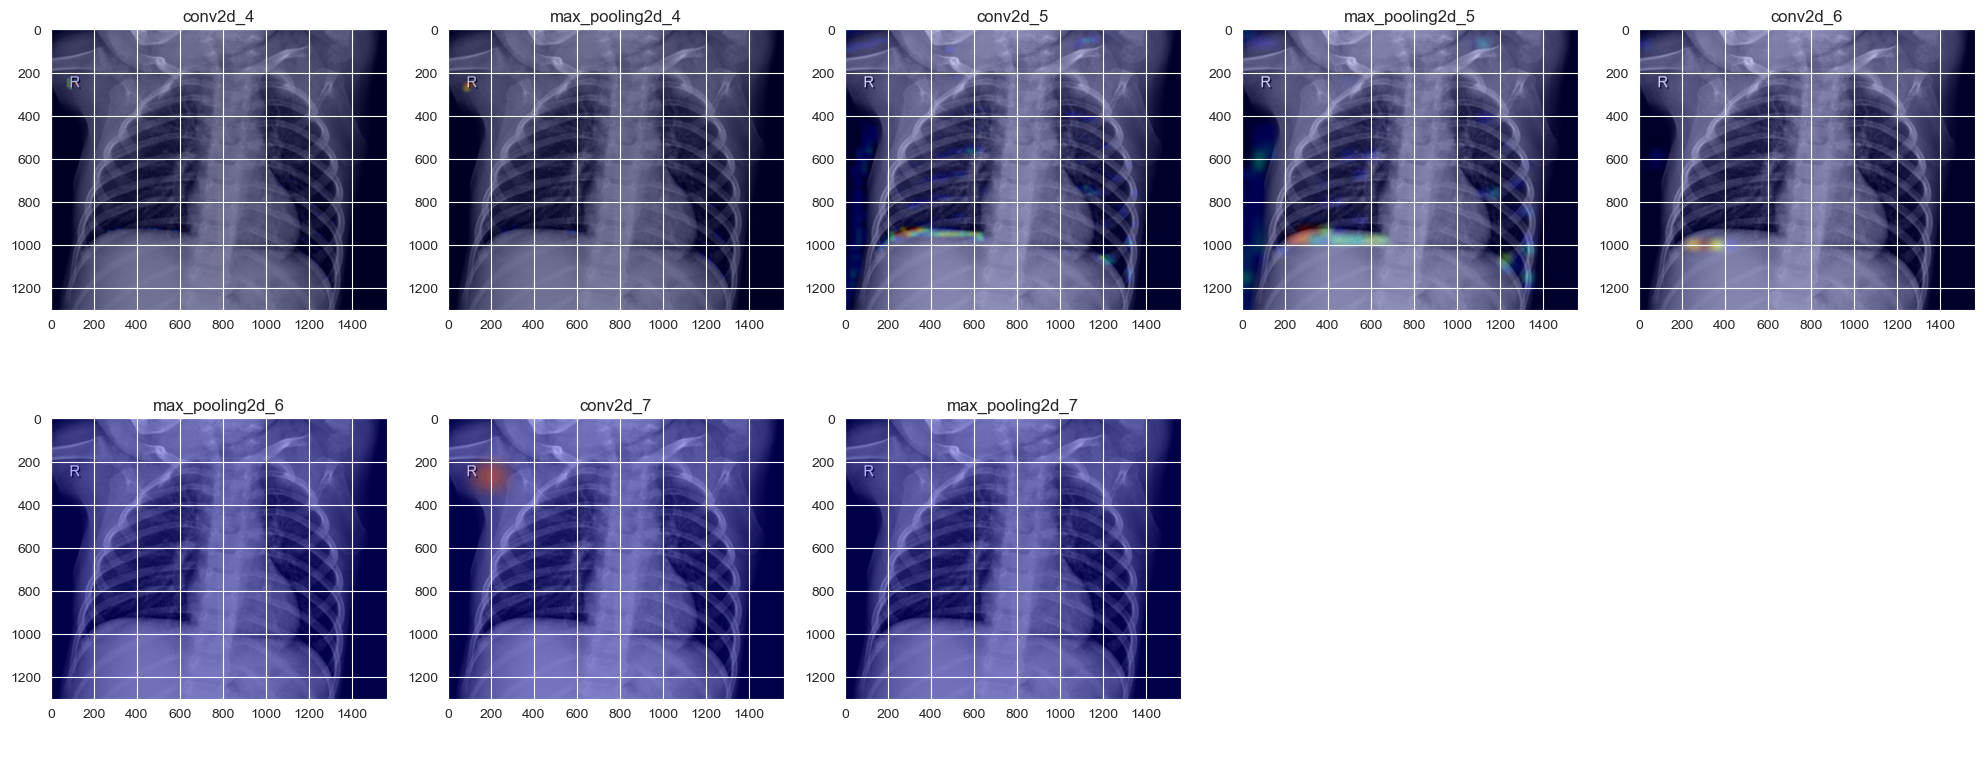

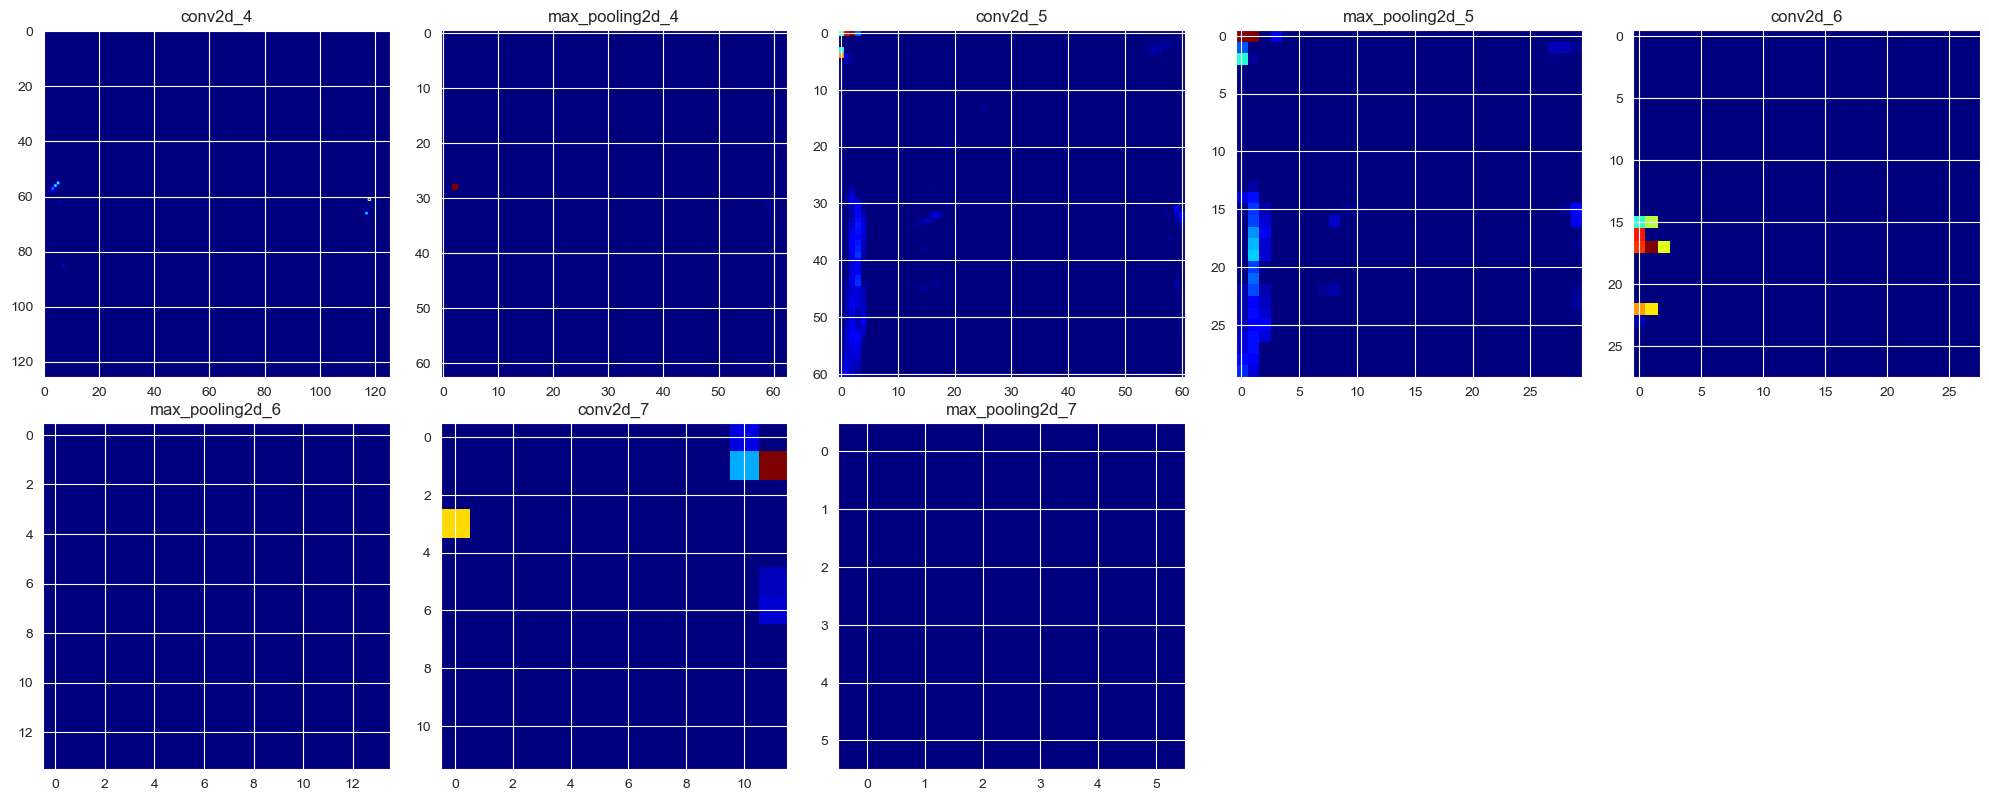

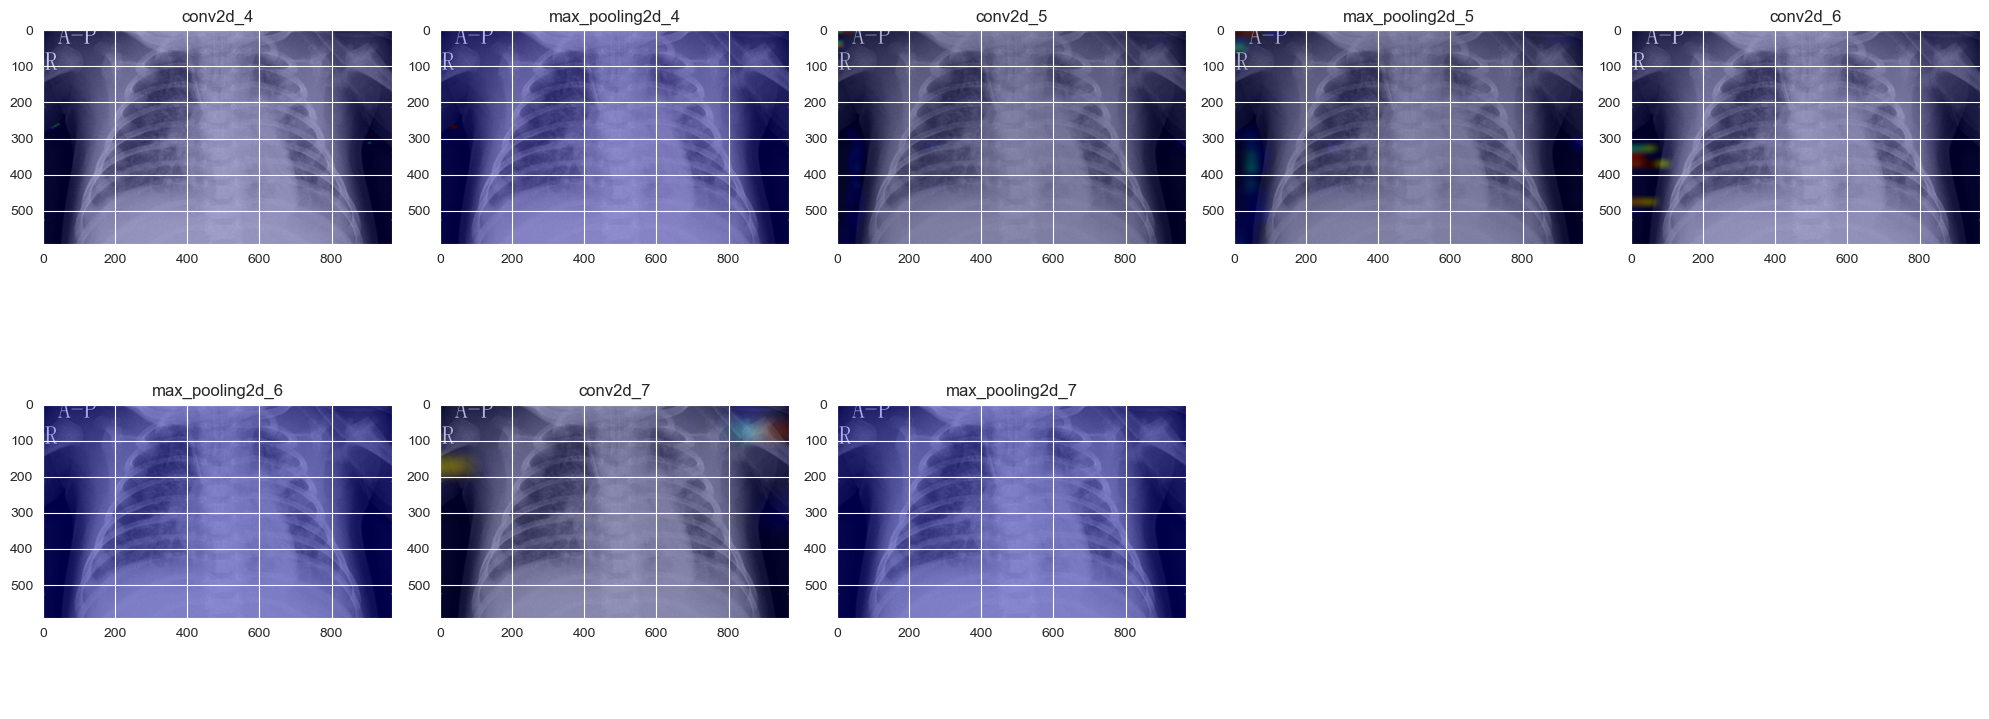

In [24]:
from common.cam import make_gradcam_heatmap, display_heatmaps

for image in images:
    heatmaps = []
    for layer in model.layers[:model.layers.index(model.get_layer(last_conv_layer_name)) + 1]:
        heatmap = make_gradcam_heatmap(image["array"], model, layer.name)
        heatmaps.append({
            "layer_name": layer.name,
            "image": heatmap
        })

    # Display heatmaps from all layers until the last max pooling layer
    display_heatmaps(image["path"], heatmaps)

    # Display the chosen image superimposed with heatmaps of each layer until the last max pooling layer
    display_heatmaps(image["path"], heatmaps, True)

In [25]:
# Predict
for image in images:
    pred = model.predict(image["array"].reshape(1, img_width, img_height, 1))
    print(pred)
    # Display predicted class
    print("Predicted class: {}".format(subfolders[int(pred[0][0])]))

1/1 [==============================] - 0s 397ms/step
[[1.]]
Predicted class: PNEUMONIA
1/1 [==============================] - 0s 12ms/step
[[1.]]
Predicted class: PNEUMONIA
